# Package importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import pickle
import gc
import math

from learning.cva_estimator_portfolio_int_pl import CVAEstimatorPortfolioInt
from learning.misc import batch_mean
from simulation.diffusion_engine_pl import DiffusionEngine

In [2]:
from numba import NumbaPerformanceWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=NumbaPerformanceWarning)

In [3]:
def open_pickle(name):
    with open('./'+name+'.pickle', 'rb') as f:
         return pickle.load(f)

def save_pickle(name,data):
    with open('./'+name+'.pickle', 'wb') as f:
        pickle.dump(data, f)

In [4]:
np.random.seed(0)
torch.manual_seed(0)

# Set seed for diffusion paths and random parameter paths
diffusion_seed = 1 #+10 for train, +20 for test, any for parameter randomization
parameter_shock_seed = 9 

In [5]:
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Simulation parameters

* `T`: portfolio maturity;
* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in \[1\]);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in \[1\]);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of \[1\]:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

**\[1\]** Abbas-Turki, L., S. Crépey, and B. Saadeddine (2023).  Pathwise CVA regressions with oversimulated defaults. Mathematical Finance 33(2), pages 274-307, 2023.

In [7]:
np.random.seed(0)
torch.manual_seed(0)

T = 10
num_coarse_steps = 100
dT = T/num_coarse_steps
num_fine_per_coarse = 25
dt = T/num_coarse_steps/num_fine_per_coarse

num_fine_steps = num_coarse_steps*num_fine_per_coarse

num_paths = 2**17
num_inner_paths = 1024#512
num_defs_per_path = 1 #256

num_rates = 10
num_spreads = 9
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.5, 0.05, num_rates).round(4)
rates_params['b'] = np.random.normal(0.03, 0.003, num_rates).round(4)
rates_params['sigma'] = np.abs(np.random.normal(0.01, 0.001, num_rates)).round(4)
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.5, 0.05, num_rates-1)).round(4)
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameter7
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.7, 0.07, num_spreads)
spreads_params['b'] = np.random.normal(0.04, 0.004, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.1, 0.01, num_spreads))
initial_values[2*num_rates-1:] = 0.015

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 64 # 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0#500 if portfolio == 'call' else 0
vanilla_specs = np.empty(num_vanillas,
                            dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])
vanilla_specs['maturity'] = np.random.uniform(0.1,9.5,num_vanillas)
vanilla_specs['notional'] = 1000. *     ((np.random.choice((-1, 1), num_vanillas, p=(0.5, 0.5)))
        * np.random.choice(range(1, 6), num_vanillas))
vanilla_specs['strike'] = abs(1. * np.random.uniform(0.9,1.1, num_vanillas))
vanilla_specs['cpty'] = np.random.randint(0, num_spreads-1, num_vanillas, np.int32)  # Counterparty with which the swap was entered into
#vanilla_specs['undl'] = np.random.randint(0, num_rates-1, num_vanillas, np.int32)  # Underlying currency
vanilla_specs['undl'] = np.random.randint(0, num_rates-1, num_vanillas, np.int32)  # Underlying currency
vanilla_specs['call_put'] = np.random.choice((True, False), num_vanillas, p=(0.5, 0.5))

num_irs = 500
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 75*dt # 0.2  # Reset frequency
irs_specs['notional'] = 10000. *  ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5))) * np.random.choice(range(1, 11), num_irs)).round(4)  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs)).round(4)  # Swap rate. To be overwritten in the ATM swaps case
irs_specs['num_resets'] = np.random.randint(int((1+dt)/(75*dt)), num_fine_steps//75+1, num_irs, np.int32) # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs, 
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

                            

In [8]:
initial_g_diff_params = np.concatenate([pd.DataFrame(rates_params).to_numpy().T.ravel(),pd.DataFrame(fx_params).to_numpy().T.ravel(),
                                        np.zeros(num_rates-1), pd.DataFrame(spreads_params).to_numpy().T.ravel()], dtype= np.float32).T
num_diff = initial_values.size
num_para = initial_g_diff_params.size + initial_values.size
'''
g1 = np.delete(np.arange(num_diff), 2*num_rates-1)
g2 = np.arange(num_diff, num_diff + num_rates)
g3 = np.arange(num_diff+ num_rates, num_diff + 2*num_rates)
g4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)
g4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)
g5 = np.arange(num_diff+ 3*num_rates, num_diff + 4*num_rates-1)
g6 = np.arange(num_diff+ 5*num_rates-1, num_diff+ 5*num_rates-1+num_spreads-1)
g7 = np.arange(num_diff+ 5*num_rates-1+num_spreads, num_diff+ 5*num_rates-1+2*num_spreads-1)
g8 = np.arange(num_diff+ 5*num_rates-1+2*num_spreads, num_diff+ 5*num_rates-1+3*num_spreads-1)
'''

'\ng1 = np.delete(np.arange(num_diff), 2*num_rates-1)\ng2 = np.arange(num_diff, num_diff + num_rates)\ng3 = np.arange(num_diff+ num_rates, num_diff + 2*num_rates)\ng4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)\ng4 = np.arange(num_diff+ 2*num_rates, num_diff + 3*num_rates)\ng5 = np.arange(num_diff+ 3*num_rates, num_diff + 4*num_rates-1)\ng6 = np.arange(num_diff+ 5*num_rates-1, num_diff+ 5*num_rates-1+num_spreads-1)\ng7 = np.arange(num_diff+ 5*num_rates-1+num_spreads, num_diff+ 5*num_rates-1+2*num_spreads-1)\ng8 = np.arange(num_diff+ 5*num_rates-1+2*num_spreads, num_diff+ 5*num_rates-1+3*num_spreads-1)\n'

Next, we select the GPU. This is where both the simulation and the training/inference are going to be performed.

In [9]:
device = torch.device('cuda:0')

num_steps_per_reset = int((irs_specs['reset_freq'][0]+dt)/(dT))
prev_reset_arr = (np.arange(num_coarse_steps+1+1)-1)//num_steps_per_reset*num_steps_per_reset
#prev_reset_arr = (np.arange(num_coarse_steps+1+1)-1)//2*2

# CVA baseline mode simulation

We then instantiate the diffusion engine and the estimators (one with default indicators and the other with default intensities).
Adding one early pricing date $t=0.01.$

In [10]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                           num_paths, 1, num_defs_per_path, 
                                           num_rates, num_spreads, R, rates_params, fx_params, 
                                           spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                           initial_values, initial_defaults, cDtoH_freq, device.index,
                                           pathwise_diff_para = np.zeros((num_para,num_paths), dtype = np.float32),
                                           early_pricing_date = [0.01], seed = diffusion_seed)

Successfully compiled all kernels.
Randomizing diffusion parameters.


In [11]:
with torch.cuda.device(device):
    _evt_start = torch.cuda.Event(enable_timing=True)
    _evt_stop = torch.cuda.Event(enable_timing=True)

In [12]:
cva_estimator = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, False, 
                                         diffusion_engine, device, 2, 2*(num_rates+num_spreads), 
                                           (num_paths*num_defs_per_path)//8, 
                                           100, 0.01, 0, reset_weights=False, linear=False, 
                                           best_sol=True, refine_last_layer=True)

In [13]:
_evt_start.record()
diffusion_engine.generate_batch(fused=True, set_irs_at_par=True)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Simulation done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 785.091 ms
Simulation done in 830.191 ms


Save diffusive risk factors and ATM interest rate specifications. 

In [14]:
baseline_diffusion_X = diffusion_engine.X.copy()
ATM_irs_specs = diffusion_engine.irs_specs.copy()

Simulate one more time without reinstantiating the diffusion engine

In [15]:
_evt_start.record()
diffusion_engine.reset_rng_states(diffusion_seed + 10) # use it for better control the seed
diffusion_engine.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Simulation done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 765.564 ms
Simulation done in 792.665 ms


In [16]:
timesteps = range(num_coarse_steps+1, -1, -1)
xi_baseline_train = np.empty((num_coarse_steps+1+1, num_defs_per_path*num_paths,1), dtype=np.float32)
cva_label_gen = cva_estimator._build_labels()
for t in timesteps:
    xi_baseline_train[t] = next(cva_label_gen)
CVA_base0 = xi_baseline_train[0].mean()

Simulate one more time for backtesting

In [17]:
_evt_start.record()
diffusion_engine.reset_rng_states(diffusion_seed + 20) # use it for better control the seed
diffusion_engine.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)
_evt_stop.record()
_evt_stop.synchronize()
elapsed_time_def = _evt_start.elapsed_time(_evt_stop)
print('Simulation done in {} ms'.format(round(elapsed_time_def, 3)))

cuda_diffuse_and_price elapsed time: 763.514 ms
Simulation done in 790.779 ms


In [18]:
timesteps = range(num_coarse_steps+1, -1, -1)
xi_baseline_test = np.empty((num_coarse_steps+1+1, num_defs_per_path*num_paths,1), dtype=np.float32)
cva_label_gen = cva_estimator._build_labels()
for t in timesteps:
    xi_baseline_test[t] = next(cva_label_gen)

In [19]:
del diffusion_engine, cva_estimator, cva_label_gen
torch.cuda.empty_cache()
gc.collect()

8635

In [20]:
(xi_baseline_test[0].mean(), xi_baseline_train[0].mean())

(4943.649, 5025.673)

# CVA sensis mode simulation

In [22]:
time_horizon_index = [1,2,11] 

# New time steps with early pricing date are:
# 0 0.01 0.1 0.2... 1

In [33]:
def parameter_shock_generator(idx_horizon, para_shock_seed = parameter_shock_seed): 
    
    #shock generation
    time_horizon_value = np.concatenate([np.array([0,1]),np.arange(10,1010,10)])
    pathwise_diff_params = np.random.RandomState(para_shock_seed).multivariate_normal(np.zeros(num_para), np.eye(num_para), size = (num_paths))
    
    shock_train = math.sqrt(time_horizon_value[idx_horizon])*0.01*np.array(pathwise_diff_params, dtype = np.float32).T
    
    pathwise_diff_params = np.random.RandomState(para_shock_seed + 111).multivariate_normal(np.zeros(num_para), np.eye(num_para), size = (num_paths))
    shock_test = math.sqrt(time_horizon_value[idx_horizon])*0.01*np.array(pathwise_diff_params, dtype = np.float32).T
    
    shock_train[0:num_diff, :] = 0
    shock_test[0:num_diff, :] = 0

    # Instantiate the diffusion engine with shocked parameters
        
    diffusion_engine_ = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                               num_paths, 1, num_defs_per_path, 
                                               num_rates, num_spreads, R, rates_params, fx_params, 
                                               spreads_params, vanilla_specs, ATM_irs_specs, zcs_specs,
                                               initial_values, initial_defaults, cDtoH_freq, device.index, 
                                               pathwise_diff_para =  shock_train.copy(),
                                               early_pricing_date =[0.01], seed = diffusion_seed+1000)
    

    diffusion_engine_.reset_rng_states(diffusion_seed + 1000)
    diffusion_engine_.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)


    shock_train[0:num_diff] = diffusion_engine_.X[idx_horizon].copy()/baseline_diffusion_X[0].copy()-1

    # Rerun for backtesting

    diffusion_engine_._reinitialize(initial_values, shock_test.copy())
    diffusion_engine_.reset_rng_states(diffusion_seed + 2000)
    diffusion_engine_.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)
       
    shock_test[0:num_diff] = diffusion_engine_.X[idx_horizon].copy()/baseline_diffusion_X[0].copy()-1
    
    del diffusion_engine_
    torch.cuda.empty_cache()
    gc.collect()
    
    return shock_train, shock_test


In [57]:
def payoff_CVA_sensis_simulation(idx_horizon, shock_train, shock_test, inner_path_nested_test = 1): 
   
    diffusion_engine_sensis = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                               num_paths, 1, num_defs_per_path, 
                                               num_rates, num_spreads, R, rates_params, fx_params, 
                                               spreads_params, vanilla_specs, ATM_irs_specs, zcs_specs,
                                               initial_values, initial_defaults, cDtoH_freq, device.index, 
                                               pathwise_diff_para =  shock_train.copy(),
                                               early_pricing_date =[0.01], seed = diffusion_seed + 10)
        
    cva_estimator_sensis = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, True, 
                                           diffusion_engine_sensis, device, 2, 2*(num_rates+num_spreads), 
                                           (num_paths*num_defs_per_path)//8, 
                                           100, 0.01, 0, reset_weights=False, linear=False, 
                                           best_sol=True, refine_last_layer=True)
    
    
    diffusion_engine_sensis.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)
    
    timesteps = range(num_coarse_steps+1, -1, -1)
    xi_sensis_train = np.empty(( num_defs_per_path*num_paths,1), dtype=np.float32)
    cva_label_gen = cva_estimator_sensis._build_labels()
    for t in timesteps:
        xi_sensis_train = next(cva_label_gen)
    
    features_sensis_ = np.empty(shape=(2, num_paths * num_defs_per_path, cva_estimator_sensis.num_features + cva_estimator_sensis.num_params * cva_estimator_sensis.include_para_as_fea))
    
    features_gen_sensis = cva_estimator_sensis._features_generator()
    
    t= 0
    next(features_gen_sensis)
    feature0 = features_gen_sensis.send(t)


    for j, feature_batch in enumerate(feature0()):
        features_sensis_[0, j*cva_estimator_sensis.batch_size:(j + 1)*cva_estimator_sensis.batch_size] = feature_batch.cpu().numpy()
            
                    
    del  diffusion_engine_sensis, cva_estimator_sensis, features_gen_sensis
    torch.cuda.empty_cache()
    gc.collect()
    
    
    ########## Rerun with nested simulation for backtesting data. We simulate num_inner_paths for nested and 2 more paths for twin Monte Carlo validation
    
 
    xi_sensis_test = np.empty((inner_path_nested_test+2, num_defs_per_path*num_paths,1), dtype=np.float32)

    
    diffusion_engine_sensis = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                               num_paths, 1, num_defs_per_path, 
                                               num_rates, num_spreads, R, rates_params, fx_params, 
                                               spreads_params, vanilla_specs, ATM_irs_specs, zcs_specs,
                                               initial_values, initial_defaults, cDtoH_freq, device.index, 
                                               pathwise_diff_para =  shock_test.copy(),
                                               early_pricing_date =[0.01], seed = diffusion_seed+ 20)
    

    cva_estimator_sensis = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, True,
                                                     diffusion_engine_sensis, device, 2, 2*(num_rates+num_spreads),
                                                     (num_paths*num_defs_per_path)//8, 
                                                     100, 0.01, 0, reset_weights=False, linear=False, 
                                                       best_sol=True, refine_last_layer=True)
    
    
    for idx_nested in tqdm(range(inner_path_nested_test+2)): # [0 ... 1024, 1025]
        diffusion_engine_sensis.reset_rng_states(diffusion_seed + 20+ idx_nested) # use it for better control the seed
        diffusion_engine_sensis.generate_batch(fused=True, nested_cva_at=None, indicator_in_cva=False, set_irs_at_par=False)
               
        timesteps = range(num_coarse_steps+1, -1, -1)
        cva_label_gen = cva_estimator_sensis._build_labels()
        for t in timesteps:
            xi_sensis_test[idx_nested] = next(cva_label_gen)
        if idx_nested==0:
            features_gen_sensis = cva_estimator_sensis._features_generator()

            t= 0
            next(features_gen_sensis)
            feature0 = features_gen_sensis.send(t)

            for j, feature_batch in enumerate(feature0()):
                features_sensis_[1, j*cva_estimator_sensis.batch_size:(j + 1)*cva_estimator_sensis.batch_size] = feature_batch.cpu().numpy()

    
    del  cva_estimator_sensis, cva_label_gen, feature0
    torch.cuda.empty_cache()
    gc.collect()
    
    return features_sensis_, xi_sensis_train, xi_sensis_test 


For each time horizon (0.01, 0.1 or 1), simulate model parameters paths and the corresponding payoffs.

In [41]:
from tqdm import tqdm

features_sensis, xi_sensis, xi_nested_sensis = list(), list(), list()
for h in tqdm(time_horizon_index):
    para_shock_train, para_shock_test = parameter_shock_generator(h)

    res = payoff_CVA_sensis_simulation(h, para_shock_train, para_shock_test, inner_path_nested_test = 1)
    
    # the first and second positions are train and backtesting data set respectively.
    features_sensis.append(res[0])
    xi_sensis.append((res[1] , res[2][0]))
    xi_nested_sensis.append(res[2])



  0%|                                                   | 0/1 [00:00<?, ?it/s]

Successfully compiled all kernels.
Randomizing diffusion parameters.
cuda_diffuse_and_price elapsed time: 778.094 ms
cuda_diffuse_and_price elapsed time: 705.944 ms
Successfully compiled all kernels.
Randomizing diffusion parameters.
cuda_diffuse_and_price elapsed time: 760.106 ms
shock_train: [[0.00911375 0.01008503 0.0096136  0.00918093 0.00828717]
 [0.01005794 0.00900015 0.00863221 0.00960001 0.01125113]
 [0.01332188 0.01001409 0.00763734 0.01012884 0.00956053]
 [0.00969358 0.01130203 0.01185182 0.01107767 0.01293877]
 [0.01249547 0.01101214 0.00663654 0.01351503 0.01264259]]
Successfully compiled all kernels.
Randomizing diffusion parameters.



 33%|██████████████▎                            | 1/3 [00:00<00:01,  1.14it/s]

cuda_diffuse_and_price elapsed time: 756.053 ms
shock_test: [[0.01164742 0.0091527  0.01075356 0.00851354 0.01180844]
 [0.00890011 0.00980096 0.01163991 0.00954665 0.00938364]
 [0.01074346 0.00916287 0.00987122 0.01223421 0.01061215]
 [0.00858414 0.00695835 0.0101984  0.00823769 0.00906631]
 [0.00726546 0.01105649 0.00776778 0.01211967 0.00807274]]



 67%|████████████████████████████▋              | 2/3 [00:01<00:00,  1.14it/s]

cuda_diffuse_and_price elapsed time: 769.672 ms
shock_test: [[0.01042488 0.00803422 0.01108098 0.0078811  0.01237984]
 [0.01067161 0.00986705 0.0128804  0.00890007 0.01110049]
 [0.00989355 0.01039087 0.01087201 0.0134368  0.00979929]
 [0.00901808 0.00937521 0.01033866 0.00993267 0.00977995]
 [0.00695206 0.00973356 0.00991743 0.01145159 0.0086639 ]]



100%|███████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s]

cuda_diffuse_and_price elapsed time: 758.06 ms
shock_test: [[0.01083212 0.00969293 0.00980485 0.00875911 0.01137615]
 [0.00993947 0.00885084 0.00980904 0.00975859 0.01067332]
 [0.009371   0.01129884 0.01098736 0.01209731 0.01128515]
 [0.00964018 0.00838638 0.0092111  0.0100491  0.0109791 ]
 [0.00549177 0.00763041 0.01095646 0.00929684 0.00921333]]



100%|███████████████████████████████████████████| 1/1 [00:57<00:00, 57.59s/it]


In [43]:
features_sensis_train = np.asarray(features_sensis, dtype = np.float32)[:,0,:,:]
features_sensis_test = np.asarray(features_sensis, dtype = np.float32)[:,1,:,:]

xi_sensis_train = np.asarray(xi_sensis, dtype = np.float32)[:,0,:,:]
xi_sensis_test = np.asarray(xi_sensis, dtype = np.float32)[:,1,:,:]

xi_nested_sensis = np.asarray(xi_nested_sensis, dtype = np.float32)

CVA_nested_test = xi_nested_sensis[:,:num_inner_paths,:,:].mean(axis = 1)
twin_y12 = xi_nested_sensis[:,num_inner_paths:,:,:]

The output results:
- `features_sensis_train[horizon, paths, num_features]`: features encomprass diffusive risk factors and parameters
- `xi_sensis_train[horizon, paths, 1]`:  payoff in the sensis mode
- `xi_sensis_test[horizon, nested paths, paths, 1]`: nested payoff in the sensis mode
- `xi_baseline_train[time_steps, paths, 1]`:  payoff in the baseline mode
- `CVA_nested_test[horizon, paths, 1]`: nested CVA in the sensis mode
- `twin_y12[time_steps, 2, paths, 1]`: payoff y1 and y2 in the sensis mode for the twin Monte Carlo validation 




## $\delta$CVA$_{(t)}$  learning (run-on)

We use neural network model model to learn $\delta$CVA$_{(t)}$.

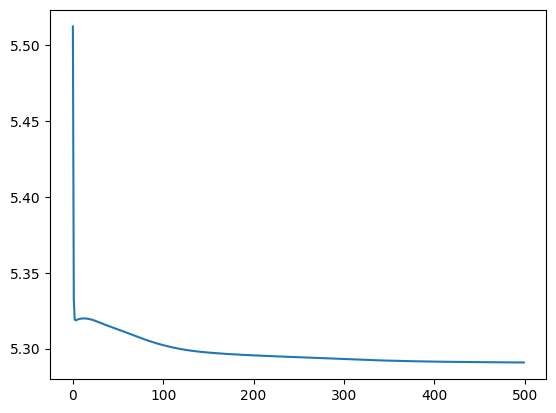

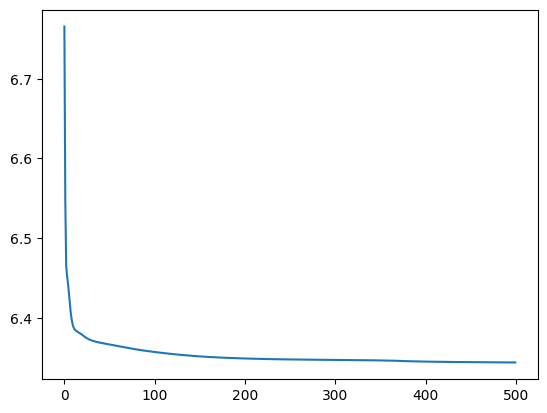

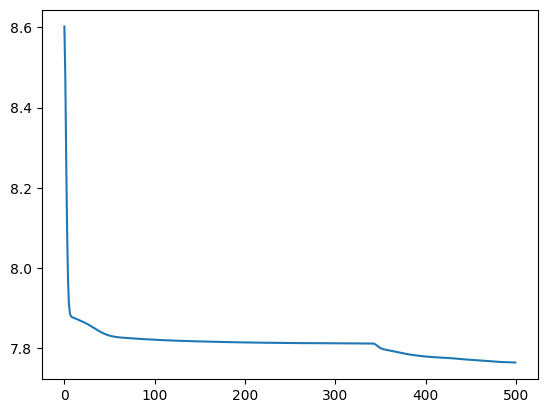

In [44]:
d_CVA_nn_train = list()
d_CVA_nn_test = list()

from learning.generic_estimator import GenericModel

criterion = torch.nn.MSELoss(reduction='mean')
num_batch = 32
batch_size = num_paths//num_batch

for j in range(len(xi_sensis)):

    dxi = torch.tensor(xi_sensis_train[j] - xi_baseline_train[0], dtype = torch.float32).to(device)
    std_dxi = dxi.std()+1e-7
    features_torch = torch.tensor(features_sensis_train[j], dtype = torch.float32).to(device)
    features_test_torch = torch.tensor(features_sensis_test[j], dtype = torch.float32).to(device)
    features_torch_mean = features_torch.mean(axis = 0,keepdim = True)
    features_torch_std = features_torch.std(axis = 0,keepdim = True)+1e-7
    
    model = GenericModel(features_torch.shape[1], 1, 200, 'mean').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2)

    model.train()
    losses = []
    for _ in range(500):
        for i in range(num_batch):
            features_batch = features_torch[i*batch_size:(i+1)*batch_size]
            labels_batch = dxi[i*batch_size:(i+1)*batch_size]
            pred = model((features_batch-features_torch_mean)/features_torch_std)
            loss = criterion(pred, labels_batch)/std_dxi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    model.eval()
    plt.plot(np.log(losses))
    plt.show()

    with torch.no_grad():
        
        pred_train = model((features_torch-features_torch_mean)/features_torch_std).cpu().numpy()
        pred_test = model((features_test_torch-features_torch_mean)/features_torch_std).cpu().numpy()
        d_CVA_nn_train.append( pred_train)
        d_CVA_nn_test.append( pred_test)
d_CVA_nn_train = np.asarray(d_CVA_nn_train, dtype = np.float32)   
d_CVA_nn_test = np.asarray(d_CVA_nn_test, dtype = np.float32)   
    

Remove unchanged features

In [45]:
idx_features_sensis = np.concatenate([np.arange(27), np.arange(45,features_sensis_train.shape[2]), np.arange(37,45)])


features_baseline0 = np.concatenate([initial_values[:-1], initial_g_diff_params, np.zeros(8)]).reshape(1,-1)

features_sensis_train = features_sensis_train[:,:,idx_features_sensis]
features_sensis_test = features_sensis_test[:,:,idx_features_sensis]



Save features, delta CVA learnt by neural network models, nested delta CVA and two extra paths for twin Monte Carlo validation

In [46]:
d = {}

d['features_baseline0'] = features_baseline0
d['features_sensis_train'] = features_sensis_train

d['features_sensis_test'] = features_sensis_test


d['d_CVA_nn_train'] = d_CVA_nn_train
d['d_CVA_nn_test'] = d_CVA_nn_test

d['d_xi_sensis_train'] = xi_sensis_train - xi_baseline_train[0:1]
d['d_xi_sensis_test'] = xi_sensis_test - xi_baseline_test[0:1]

d['d_CVA_nested_test'] = CVA_nested_test - CVA_base0

d['d_twin_y12'] = twin_y12 - CVA_base0


d['CVA_0'] = CVA_base0


In [47]:
with open('data_for_run-on_analysis.pickle', 'wb') as file:
    pickle.dump(d,file)